# Drug-Domain Retrieval - Figure 5ab

In [61]:
import torch
import torch.nn.functional as F
from procyon.model.model_unified import UnifiedProCyon

Change checkpoint name below:

In [62]:
CKPT_NAME = "/n/holylfs06/LABS/mzitnik_lab/Lab/PLM/REPRO/ProCyon-Full"

In [63]:
# Loading the model and transitioning to device:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model, _ = UnifiedProCyon.from_pretrained(checkpoint_dir=CKPT_NAME)
model.to(device)
model.eval()

updating model args DATA_DIR from /n/holystore01/LABS/mzitnik_lab/Lab/PLM -> /n/holylfs06/LABS/mzitnik_lab/Lab/PLM
updating stale DATA_DIR for model arg: go_embeddings_path
updating stale DATA_DIR for model arg: pfam_embeddings_path
updating stale DATA_DIR for model arg: drugbank_embeddings_path
updating stale DATA_DIR for model arg: reactome_embeddings_path
updating stale DATA_DIR for model arg: omim_embeddings_path
updating stale DATA_DIR for model arg: ec_embeddings_path
updating stale DATA_DIR for model arg: protein_seq_embeddings_path
updating stale DATA_DIR for model arg: protein_struct_embeddings_path
updating stale DATA_DIR for model arg: protein_embeddings_idmap_path
updating stale DATA_DIR for model arg: drug_struct_embeddings_path
updating stale DATA_DIR for model arg: domain_embeddings_path
updating stale DATA_DIR for model arg: domain_embeddings_idmap_path
updating stale DATA_DIR for model arg: mouse_ortholog_embeddings_path
updating stale DATA_DIR for model arg: mouse_ort

/n/home06/oqueen/.conda/envs/ProCyon/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Some weights of LlamaForCausalLM were not initialized from the model checkpoint at meta-llama/Meta-Llama-3-8B and are newly initialized: ['model.layers.21.self_attn.rotary_emb.inv_freq', 'model.layers.20.self_attn.rotary_emb.inv_freq', 'model.layers.3.self_attn.rotary_emb.inv_freq', 'model.layers.24.self_attn.rotary_emb.inv_freq', 'model.layers.13.self_attn.rotary_emb.inv_freq', 'model.layers.29.self_attn.rotary_emb.inv_freq', 'model.layers.2.self_attn.rotary_emb.inv_freq', 'model.layers.11.self_attn.rotary_emb.inv_freq', 'model.layers.4.self_attn.rotary_emb.inv_freq', 'model.layers.15.self_attn.rotary_emb.inv_freq', 'model.layers.1.self_attn.rotary_emb.inv_freq', 'model.layers.16.self_attn.rotary_emb.inv_freq', 'model.layers.25.self_attn.rotary_emb.inv_freq', 'model.layers.0.self_attn.rotary_emb.inv_freq', 'model.layers.14.self_attn.rotary_emb.inv_freq', 'model.layers.30.self_attn.rotary_emb.inv_freq', 'model.layers.28.self_attn.rotary_emb.inv_freq', 'model.layers.18.self_attn.rotary_

Processing zero checkpoint '/n/holylfs06/LABS/mzitnik_lab/Lab/PLM/REPRO/ProCyon-Full/global_step59469'
Detected checkpoint of type zero stage ZeroStageEnum.gradients, world_size: 32
Parsing checkpoint created by deepspeed==0.12.4
Reconstructed fp32 state dict with 322 params 8141117441 elements


UnifiedProCyon(
  (text_encoder): LlamaPostTokenization(
    (model): LlamaForCausalLM(
      (model): LlamaModel(
        (embed_tokens): Embedding(128263, 4096)
        (layers): ModuleList(
          (0-31): 32 x LlamaDecoderLayer(
            (self_attn): LlamaAttention(
              (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
              (k_proj): Linear(in_features=4096, out_features=1024, bias=False)
              (v_proj): Linear(in_features=4096, out_features=1024, bias=False)
              (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
              (rotary_emb): LlamaRotaryEmbedding()
            )
            (mlp): LlamaMLP(
              (gate_proj): Linear(in_features=4096, out_features=14336, bias=False)
              (up_proj): Linear(in_features=4096, out_features=14336, bias=False)
              (down_proj): Linear(in_features=14336, out_features=4096, bias=False)
              (act_fn): SiLUActivation()
            )
     

In [64]:
import os
HOME_DIR = os.getenv("HOME_DIR")
DATA_DIR = "/n/holylfs06/LABS/mzitnik_lab/Lab/PLM/REPRO/ProCyon-Instruct/"
#DATA_DIR = os.getenv("DATA_DIR")
# Make sure this line runs, follow instructions in GitHub README to set HOME_DIR

In [65]:
data_args = torch.load(os.path.join(CKPT_NAME, "data_args.pt"))
train_args = torch.load(os.path.join(CKPT_NAME, "training_args.pt"))

In [66]:
# Load saved embeddings for this model:
all_protein_embeddings, all_protein_ids = torch.load(os.path.join(CKPT_NAME, "protein_target_embeddings.pkl"))
# Confirm with size:
all_protein_embeddings = all_protein_embeddings.float()
print(all_protein_embeddings.shape)

torch.Size([18174, 2560])


In [67]:
all_domain_embeddings, all_domain_ids = torch.load(os.path.join(CKPT_NAME, "domain_target_embeddings.pkl"))
all_domain_embeddings = all_domain_embeddings.float()
print(all_domain_embeddings.shape)

torch.Size([41486, 2560])


## Functions to set up inputs:

Below I'll define some functions that are useful to construct inputs. These create the template needed for retrieval querying, including adding the famous `[PROT]` token 

In [68]:
import json
import pandas as pd
from typing import List
from procyon.data.data_utils import get_text_sequences_compositions
from procyon.data.it_collator import construct_task_id
from procyon.data.instruct_tune.instruct_constructor import get_prompt, get_prompt_open_def

from procyon.data.constants import RETRIEVAL_SUBSETS

UNIPROT_IDS = pd.read_pickle(os.path.join(DATA_DIR, "integrated_data/v1/protein/", "protein_info_filtered.pkl"))[["index", "protein_id", "name"]]
DRUGMASK = torch.load(os.path.join(DATA_DIR, f"integrated_data/v1/drugbank/drugbank_mask.pt"))

def uniprot_id_to_index(uniprot_id):
    assert (UNIPROT_IDS["protein_id"] == uniprot_id).sum() == 1, "ID {} not found in internal database".format(uniprot_id)
    i = UNIPROT_IDS["index"].loc[UNIPROT_IDS["protein_id"] == uniprot_id].item()
    return i

def index_to_uniprot_id(i):
    uniprot_id = UNIPROT_IDS["protein_id"].loc[UNIPROT_IDS["index"] == i].item()
    return uniprot_id

def create_input_retrieval(
        input_description: str = None,
        input_context: str = None,
        drug_input_idx: List[int] = None,
        task_definition: str = None,
        instruction_source_dataset: str = None,
        instruction_source_relation: str = "all",
        aaseq_type: str = "protein",
        icl_example_number: int = 1,
    ):
    '''
    Args:
        input_description: str
            - Input description on which to query
        task_definition: str
            - If provided, this will replace the part after the "Definition: " tag in the instructions
        instruction_source_dataset: str
            - Should describe the dataset, or text type
            - Options: ["disgenet", "pfam", "drugbank", "ec", "go", "gtop", "omim", "uniprot", "reactome", "protein" (which is STRING protein-protein)]
        instruction_source_relation: str
            - Should describe the relation within that dataset
            - For most datasets, this is "all", but for some datasets you can make it more precise:
                go: "process", "function", "component"
                drugbank: "target", "carrier", "enzyme", "transporter"
                protein: "coexpression", "homology", "experiments"
        aaseq_type: str
            - Should be "protein", "domain", or later "peptide"
            - Tells the model which embedding layer we should access, i.e., embeddings for domains or proteins
            - Also important for defining the instruction - ex: domain-go vs. protein-gok
        icl_example_number: int
            - Number of in-context examples to use for the given dataset
            - We use 1 in all of our training, so recommended to set to 1
            - Options: [0, 1, 2]
    ''' 

    task_type = "retreival"

    example_descriptions = []
    if instruction_source_dataset is not None:
        instruction_source_dataset = instruction_source_dataset.lower()
        
        # Load instructions from instruction constructor
        task_id = construct_task_id(aaseq_type = aaseq_type, 
                                    text_type = instruction_source_dataset, 
                                    relation_type = instruction_source_relation, 
                                    task_type = 'retrieval')
        fpath = os.path.join(HOME_DIR, f"procyon/data/instruct_tune/tasks/{task_id}.json")
        
        with open(fpath, "r") as j:
            task_json = json.loads(j.read())

        get_prompt_fn = get_prompt if (task_definition is None) else get_prompt_open_def

        if task_definition is None:
            instruction, _, _, example_text_ids, example_aaseq_ids = get_prompt(task = task_json, 
                    num_examples = icl_example_number,
                    is_special_definition = False,
                    is_ppi = (instruction_source_dataset == 'protein'),
                    aaseq_type = aaseq_type,
                )
        else:
            instruction, _, _, _, example_text_ids, example_aaseq_ids = get_prompt_open_def(task = task_json, 
                    num_examples = icl_example_number,
                    is_special_definition = False,
                    is_ppi = (instruction_source_dataset == 'protein'),
                    aaseq_type = aaseq_type,
                )

            instruction = instruction.format(definition=task_definition)

        col_subset = RETRIEVAL_SUBSETS[data_args.retrieval_subset_version]

        text_df = pd.read_pickle(DATA_DIR+f"integrated_data/v1/{instruction_source_dataset}/{instruction_source_dataset}_info_filtered_composed.pkl")
        text_sequences = get_text_sequences_compositions(
            text_type = instruction_source_dataset,
            text_info = text_df,
            column_subset = col_subset,
        )

        # Get example text
        example_descriptions = text_sequences.iloc[example_text_ids,0].tolist()

        input_drug = None
        drug_inputs = None
        if (instruction_source_dataset == 'drugbank') and (drug_input_idx is not None):
            input_drug = []
            drug_inputs = []
            for i in range(len(example_descriptions)):
                if not DRUGMASK[example_text_ids[i]]:
                    continue
                example_descriptions[i] = example_descriptions[i] + "\nDrug: <|drug|>"
                input_drug.append(i)
                drug_inputs.append(example_text_ids[i])
                # add to drug input
        
    else:
        raise NotImplementedError

    if drug_input_idx is not None:

        # Automatic detection of if we have drug embeddings for this specific sample:
        if DRUGMASK[drug_input_idx].item():
            # Insert drug info:
            input_description = input_description + "\nDrug: <|drug|>"
            input_drug.append(len(input_drug))
            drug_inputs.append(drug_input_idx)
            # input_drug = torch.LongTensor([[0]]).tolist()
            # drug_inputs = torch.LongTensor([drug_input_idx]).to(device)
        else:
            warnings.warn("WARNING: not inserting drug index because we don't have one in our database")
            input_drug = None
            drug_inputs = None
        
    else:
        input_drug = None
        drug_inputs = None

    if input_drug is not None:
        input_drug = torch.LongTensor(input_drug).unsqueeze(0).tolist()
        drug_inputs = torch.LongTensor(drug_inputs).to(device)

    unique_aaseq_indices = torch.LongTensor(example_aaseq_ids).to(device)
    descriptions = example_descriptions + [input_description]
        
    instruction = instruction[:-5] if instruction[-5:] == "[EXT]" else instruction # Trim EXT

    instruction = instruction.replace("[CONTEXT]", "")

    model_input = {
            "data": {
                "seq": unique_aaseq_indices,
                "seq_idx": unique_aaseq_indices,
                "text": descriptions,
                "drug": drug_inputs, # Optional
            },
            "input": {
                "seq": torch.arange((unique_aaseq_indices).shape[0]).unsqueeze(0).tolist(),
                "text": torch.arange(len(descriptions)).unsqueeze(0).tolist(), # List not tensor
                "drug": input_drug,
                #"drug": np.arange(len(unique_drug_indices)).tolist(),
            },
            "target": { # This is only used for training
                "seq": None,
                "text": None,
                "drug": None,
            },
            "instructions": [instruction],
        }

    # return model_input
    return model_input
    

The below code references the library of uniprot IDs for proteins (set of human proteins that we consider for retrieved library).

In [69]:
def get_proteins_from_embedding(model_out = None, embedding_direct = None, top_k = 20):
    '''
    Inputs:
        model_out: dictionary
            - Of the form of output from model, accesses the query embedding as shown below
        top_k: int
            - Number of top proteins to retrieve for the scoring
            - Set this to None if you want the whole dataframe
    '''
    # Get embedding:
    if model_out is None:
        assert embedding_direct is not None
        query_embedding = F.normalize(embedding_direct, dim=-1)
    else:
        query_embedding = model_out["contrastive_out"]["positive"]["text"][0,:].unsqueeze(0).detach().clone()
        query_embedding = F.normalize(query_embedding, dim=-1)

    # Now compute similarities to all proteins:
    # all_protein_embeddings might already be normalized, but in this case, normalize() is an identify function
    sims = torch.matmul(query_embedding.cuda(), F.normalize(all_protein_embeddings, dim=-1).transpose(0,1).cuda()).squeeze()

    # Rank distances:
    sort_inds = torch.argsort(sims, descending=True)
    if top_k is not None:
        top20 = sort_inds[:top_k].detach().clone().cpu().tolist()
        top20_mapped = [all_protein_ids[i] for i in top20]
        sim_sub= sims[sort_inds[:top_k]].detach().clone().cpu().tolist()
    else:
        top20 = sort_inds.detach().clone().cpu().tolist()
        top20_mapped = [all_protein_ids[i] for i in sort_inds]
        sim_sub= sims[sort_inds].detach().clone().cpu().tolist()
    
    ids = UNIPROT_IDS["protein_id"].iloc[top20]
    names = UNIPROT_IDS["name"].iloc[top20]
    
    # Construct pd and print:
    df = pd.DataFrame({"uniprot_id": ids, "name": names, "sim_score":sim_sub})

    return df

In [70]:
def ranking_sim_from_embedding(model_out, reference_embeddings, top_k = 20):
    '''
    Inputs:
        model_out: dictionary
            - Of the form of output from model, accesses the query embedding as shown below
        top_k: int
            - Number of top proteins to retrieve for the scoring
            - Set this to None if you want the whole dataframe
    '''
    # Get embedding:
    query_embedding = model_out["contrastive_out"]["positive"]["text"][0,:].unsqueeze(0).detach().clone()
    query_embedding = F.normalize(query_embedding, dim=-1)

    # Now compute similarities to all proteins:
    # all_protein_embeddings might already be normalized, but in this case, normalize() is an identify function
    sims = torch.matmul(query_embedding.cuda(), F.normalize(reference_embeddings, dim=-1).transpose(0,1).cuda()).squeeze()

    # Rank distances:
    sort_inds = torch.argsort(sims, descending=True)
    if top_k is not None:
        topk_inds = sort_inds[:top_k].detach().clone().cpu().tolist()
        sim_sub= sims[sort_inds[:top_k]].detach().clone().cpu().tolist()
    else:
        topk_inds = sort_inds.detach().clone().cpu().tolist()
        sim_sub= sims[sort_inds].detach().clone().cpu().tolist()
    
    # Construct pd and print:
    df = pd.DataFrame({"index": topk_inds, "sim_score":sim_sub})

    return df

In [71]:
# Load all reference files for Drug-Domain dataset:
drugdomain = pd.read_pickle(DATA_DIR + "experimental_data/DomainDrug/DomainDrug_processed_mapped.pkl")

In [72]:
drugdomain

,drugbank_id,domain_id,Interacting_residues,domain_index,drugbank_index,uniprot_id,shift_+-20,mapped_residues_+-20,domain_start,domain_end,mapped_residues_+-20_in_domain
0,DB00114,O15382_PF01063_100,"[MET_241, GLY_312, THR_313, VAL_270, SER_311, ...",3229,93,O15382,NaN,[],100,351,[]
1,DB00114,P04181_PF00202_51,"[VAL_143, GLU_235, GLU_144, LYS_292, GLY_142, ...",22564,93,P04181,0.0,"[V_143, E_235, E_144, K_292, G_142, I_265, S_3...",51,437,"[V_143, E_235, E_144, K_292, G_142, I_265, S_3..."
2,DB00114,P11216_PF00343_114,"[ARG_138, TRP_491, THR_676, ASN_678, LYS_574, ...",26433,93,P11216,1.0,"[R_139, W_492, T_677, N_679, K_575, G_678, R_6...",114,829,"[R_139, W_492, T_677, N_679, K_575, G_678, R_6..."
3,DB00114,P11926_PF00278_41,"[GLY_235, TYR_389, PHE_238, PHE_192, LEU_166, ...",7869,93,P11926,NaN,[],41,388,[]
4,DB00114,P11926_PF02784_45,"[GLY_235, TYR_389, PHE_238, PHE_192, LEU_166, ...",7870,93,P11926,NaN,[],45,282,[]
...,...,...,...,...,...,...,...,...,...,...,...
516,DB15031,O43613_PF00001_63,"[MET_183, HIS_344, CYS_99, GLN_126, TYR_53, GL...",23071,2913,O43613,0.0,"[M_183, H_344, C_99, Q_126, Y_53, Q_179, H_216...",63,359,"[M_183, H_344, C_99, Q_126, Q_179, H_216, C_20..."
517,DB15133,P08581_PF07714_1079,"[VAL_1092, ALA_1226, TYR_1159, ALA_1221, GLY_1...",19127,2924,P08581,0.0,"[V_1092, A_1226, Y_1159, A_1221, G_1085, H_116...",1079,1337,"[V_1092, A_1226, Y_1159, A_1221, G_1085, H_116..."
518,DB15149,P11362_PF07714_479,"[VAL_561, ILE_639, MET_535, TYR_563, PHE_642, ...",11151,2925,P11362,0.0,"[V_561, I_639, M_535, Y_563, F_642, A_640, E_4...",479,755,"[V_561, I_639, M_535, Y_563, F_642, A_640, E_4..."
519,DB15250,P51686_PF00001_65,"[LEU_88, LEU_87, PHE_324, VAL_320, GLU_322, TY...",4742,2930,P51686,NaN,[],65,318,[]


In [73]:
import numpy as np
pid_set = UNIPROT_IDS["protein_id"].tolist()
print(np.array([p in pid_set for p in drugdomain["uniprot_id"]]).sum())

521


In [74]:
drugdomain.shape

(521, 11)

In [75]:
# Verify domains:
DOMAIN_IDS = pd.read_pickle(DATA_DIR + "integrated_data/v1/domain/domain_info_filtered.pkl")

did_set = DOMAIN_IDS["domain_id"].tolist()
print(np.array([d in did_set for d in drugdomain["domain_id"]]).sum())

521


In [76]:
# Verify the domain indices:
DOMAIN_IDS["domain_id"].iloc[drugdomain["domain_index"]]
#( == drugdomain["domain_id"]).sum()

3229      O15382_PF01063_100
22564     O75147_PF07679_918
26433    P27708_PF01979_1464
7869       P11926_PF00278_41
7870       P11926_PF02784_45
                ...         
23071     Q96HP4_PF00175_174
19127     Q86XN8_PF13920_598
11151     P11362_PF07714_479
4742       P51686_PF00001_65
34283      Q9BTX7_PF03765_67
Name: domain_id, Length: 521, dtype: object

In [77]:
drugdomain["domain_id"] # Looks good!

0       O15382_PF01063_100
1        P04181_PF00202_51
2       P11216_PF00343_114
3        P11926_PF00278_41
4        P11926_PF02784_45
              ...         
516      O43613_PF00001_63
517    P08581_PF07714_1079
518     P11362_PF07714_479
519      P51686_PF00001_65
520     P33981_PF00069_525
Name: domain_id, Length: 521, dtype: object

So we have a few rows here that are meaningful:
1. `uniprot_id`: which protein this drug interacts with
2. `domain_id`: which domain interacts with the drug
3. `drugbank_id`: which drugbank entry matches the given row

In [78]:
# Load protein->domain mapper:
domain_to_protein_df = pd.read_pickle(DATA_DIR + "integrated_data/v1/protein/protein_domains.pkl")

In [79]:
domain_to_protein_df

,protein_id,ensp,ensg,Pfam start,Pfam end,Pfam ID,name,entry,comments,domain_id
0,P31946,ENSP00000300161,ENSG00000166913,11.0,231.0,PF00244,YWHAB,1433B_HUMAN,[FUNCTION: Adapter protein implicated in the r...,P31946_PF00244_11
1,P62258,ENSP00000264335,ENSG00000108953,10.0,232.0,PF00244,YWHAE,1433E_HUMAN,[FUNCTION: Adapter protein implicated in the r...,P62258_PF00244_10
2,Q04917,ENSP00000248975,ENSG00000128245,11.0,234.0,PF00244,YWHAH,1433F_HUMAN,[FUNCTION: Adapter protein implicated in the r...,Q04917_PF00244_11
3,P61981,ENSP00000306330,ENSG00000170027,10.0,234.0,PF00244,YWHAG,1433G_HUMAN,[FUNCTION: Adapter protein implicated in the r...,P61981_PF00244_10
4,P31947,ENSP00000340989,ENSG00000175793,9.0,231.0,PF00244,SFN,1433S_HUMAN,[FUNCTION: Adapter protein implicated in the r...,P31947_PF00244_9
...,...,...,...,...,...,...,...,...,...,...
42163,O43149,ENSP00000371051,ENSG00000074755,259.0,380.0,PF03256,ZZEF1 {ECO:0000312|HGNC:HGNC:29027},ZZEF1_HUMAN,[FUNCTION: Histone H3 reader which may act as ...,O43149_PF03256_259
42164,O43149,ENSP00000371051,ENSG00000074755,1781.0,1812.0,PF00569,ZZEF1 {ECO:0000312|HGNC:HGNC:29027},ZZEF1_HUMAN,[FUNCTION: Histone H3 reader which may act as ...,O43149_PF00569_1781
42165,O43149,ENSP00000371051,ENSG00000074755,1828.0,1869.0,PF00569,ZZEF1 {ECO:0000312|HGNC:HGNC:29027},ZZEF1_HUMAN,[FUNCTION: Histone H3 reader which may act as ...,O43149_PF00569_1828
42167,Q8IYH5,ENSP00000359837,ENSG00000036549,655.0,702.0,PF00249,ZZZ3,ZZZ3_HUMAN,[FUNCTION: Histone H3 reader that is required ...,Q8IYH5_PF00249_655


In [80]:
# Need to build a multi-domain list:
u_uni_ids = domain_to_protein_df["protein_id"].unique().tolist()
uniprot_id_to_domains = {u:[] for u in u_uni_ids}

for i, row in domain_to_protein_df[["protein_id", "domain_id"]].iterrows():
    uniprot_id_to_domains[row["protein_id"]].append(row["domain_id"])

In [81]:
u_uni_ids = drugdomain["uniprot_id"].unique().tolist()
uniprot_id_to_domains_drug = {u:[] for u in u_uni_ids}

for i, row in drugdomain[["uniprot_id", "domain_id"]].iterrows():
    uniprot_id_to_domains_drug[row["uniprot_id"]].append(row["domain_id"])

In [82]:
import matplotlib.pyplot as plt

findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic f

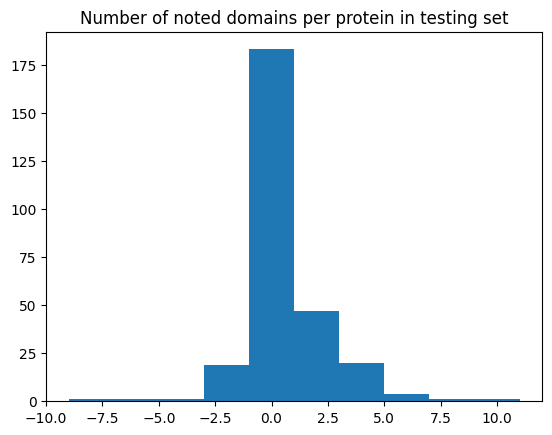

In [83]:
Ldd = drugdomain["uniprot_id"].tolist()
len_dist = [len(domains) - len(uniprot_id_to_domains_drug[id]) for id, domains in uniprot_id_to_domains.items() if (id in Ldd)]

plt.title("Number of noted domains per protein in testing set")
plt.hist(len_dist)
plt.show()

Criterion: number of domains in protein vs. binding domains must be greater than 1 (so 3 minimum domains in the protein)

In [84]:
inc_pids = [id for id, domains in uniprot_id_to_domains_drug.items() if (len(uniprot_id_to_domains[id]) - len(domains)) > 1]

In [85]:
# Filter drug-domain by inc_pids:
inc_set = set(inc_pids)
drugdomain_filtered = drugdomain.loc[drugdomain["uniprot_id"].isin(inc_set),:]

In [86]:
drugdomain_filtered.shape

(48, 11)

In [87]:
drugdomain_filtered

,drugbank_id,domain_id,Interacting_residues,domain_index,drugbank_index,uniprot_id,shift_+-20,mapped_residues_+-20,domain_start,domain_end,mapped_residues_+-20_in_domain
31,DB00119,P11498_PF00682_565,"[PHE_677, ARG_644, GLY_609, GLN_575, LEU_642, ...",26428,98,P11498,0.0,"[F_677, R_644, G_609, Q_575, L_642, V_907, T_9...",565,836,"[F_677, R_644, G_609, Q_575, L_642, R_571, A_6..."
32,DB00119,P11498_PF02436_861,"[PHE_677, ARG_644, GLY_609, GLN_575, LEU_642, ...",26429,98,P11498,0.0,"[F_677, R_644, G_609, Q_575, L_642, V_907, T_9...",861,1062,"[V_907, T_908]"
98,DB00171,O14727_PF00931_130,"[GLY_159, TYR_359, PRO_321, SER_325, VAL_127, ...",1834,148,O14727,0.0,"[G_159, Y_359, P_321, S_325, V_127, I_294, G_1...",130,375,"[G_159, Y_359, P_321, S_325, I_294, G_157, A_1..."
107,DB00171,P33527_PF00005_661,"[THR_660, GLY_681, SER_685, CYS_682, VAL_680, ...",19809,148,P33527,0.0,"[T_660, G_681, S_685, C_682, V_680, W_653, S_6...",661,796,"[G_681, S_685, C_682, V_680, S_686, Q_679, G_6..."
132,DB00227,P20701_PF00092_156,"[LEU_302, LYS_305, ILE_255, TYR_257, ILE_235, ...",15108,203,P20701,NaN,[],156,326,[]
157,DB00360,P29474_PF02898_121,"[ARG_365, PHE_460, GLN_462, ILE_448, TRP_74, L...",21758,320,P29474,0.0,"[R_365, F_460, Q_462, I_448, W_74, L_103, E_46...",121,482,"[R_365, F_460, Q_462, I_448, E_463, V_449, H_4..."
175,DB00491,O43451_PF01055_349,"[ASP_203, TYR_299, GLY_541, TRP_539, ARG_598, ...",19206,441,O43451,NaN,[],349,821,[]
176,DB00491,P10253_PF01055_340,"[GLY_615, PHE_649, LEU_405, TRP_481, ASP_645, ...",18291,441,P10253,0.0,"[G_615, F_649, L_405, W_481, D_645, F_525, D_4...",340,825,"[G_615, F_649, L_405, W_481, D_645, F_525, D_4..."
185,DB00551,P39900_PF00413_109,"[ALA_184, HIS_183, GLU_219, ALA_182, HIS_228, ...",19425,495,P39900,0.0,"[A_184, H_183, E_219, A_182, H_228, I_180, H_2...",109,264,"[A_184, H_183, E_219, A_182, H_228, I_180, H_2..."
221,DB00773,P11388_PF00521_713,"[GLU_506, GLU_461, DG_7, DC_14, DA_12, MET_762...",33527,696,P11388,0.0,"[E_506, E_461, M_762, M_766, G_462, S_464, P_8...",713,1172,"[M_762, M_766, P_803]"


In [88]:
drugdomain_filtered["uniprot_id"].unique().shape

(34,)

In [89]:
# Get drugbank info:
drugbank_info = pd.read_pickle(DATA_DIR + "integrated_data/v1/drugbank/drugbank_info_filtered_composed.pkl")
drugbank_info

,index,drugbank_id,drug_name,atc_codes,description,indication,pharmacodynamics,moa,absorption,metabolism,toxicity,description_name_description,description_name_description_moa_pharmacodynamics,description_name_description_moa_pharmacodynamics_indication_toxicity
0,0,DB00001,Lepirudin,"[B01AE, B01A, B01, B]",Lepirudin is a recombinant hirudin formed by 6...,Lepirudin is indicated for anticoagulation in ...,Lepirudin is a recombinant hirudin that acts a...,Lepirudin is a direct thrombin inhibitor used ...,Lepirudin administered as a single intravenous...,"As a polypeptide, lepirudin is expected to be ...",The acute toxicity of intravenous lepirudin wa...,Name: Lepirudin.\n\nDefinition: Lepirudin is a...,Name: Lepirudin.\n\nDefinition: Lepirudin is a...,Name: Lepirudin.\n\nDefinition: Lepirudin is a...
1,1,DB00002,Cetuximab,"[L01FE, L01F, L01, L]",Cetuximab is a recombinant chimeric human/mous...,Cetuximab indicated for the treatment of local...,Cetuximab is an anticancer agent that works by...,The epidermal growth factor receptor (EGFR) is...,After administration of a 400 mg/m<sup>2</sup>...,"Like other monoclonal antibodies, cetuximab is...",The intravenous LD<sub>50</sub> is > 300 mg/kg...,Name: Cetuximab.\n\nDefinition: Cetuximab is a...,Name: Cetuximab.\n\nDefinition: Cetuximab is a...,Name: Cetuximab.\n\nDefinition: Cetuximab is a...
2,2,DB00004,Denileukin diftitox,"[L01XX, L01X, L01, L]",A recombinant DNA-derived cytotoxic protein co...,For treatment of cutaneous T-cell lymphoma,Denileukin diftitox (Ontak) directs the cytoci...,Denileukin diftitox binds to the high-affinity...,,,,Name: Denileukin diftitox.\n\nDefinition: A re...,Name: Denileukin diftitox.\n\nDefinition: A re...,Name: Denileukin diftitox.\n\nDefinition: A re...
3,3,DB00005,Etanercept,"[L04AB, L04A, L04, L]",Dimeric fusion protein consisting of the extra...,Etanercept is indicated for the treatment of m...,Etanercept binds specifically to tumor necrosi...,There are two distinct receptors for TNF (TNFR...,Population pharmacokinetic modeling in adults ...,"As etanercept is a fusion protein antibody, it...",,Name: Etanercept.\n\nDefinition: Dimeric fusio...,Name: Etanercept.\n\nDefinition: Dimeric fusio...,Name: Etanercept.\n\nDefinition: Dimeric fusio...
4,4,DB00006,Bivalirudin,"[B01AE, B01A, B01, B]",Bivalirudin is a synthetic 20 residue peptide ...,For treatment of heparin-induced thrombocytope...,Bivalirudin mediates an inhibitory action on t...,Inhibits the action of thrombin by binding bot...,"Following intravenous administration, bivaliru...",80% proteolytic cleavage,"Based on a study by Gleason et al., the no-obs...",Name: Bivalirudin.\n\nDefinition: Bivalirudin ...,Name: Bivalirudin.\n\nDefinition: Bivalirudin ...,Name: Bivalirudin.\n\nDefinition: Bivalirudin ...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3013,3013,DB16738,Ciltacabtagene autoleucel,[],Multiple myeloma is a malignancy involving the...,Ciltacabtagene autoleucel is indicated for the...,Treatment with ciltacabtagene autoleucel compr...,Ciltacabtagene autoleucel is a chimeric antige...,Following a single infusion of a median dose o...,,,Name: Ciltacabtagene autoleucel.\n\nDefinition...,Name: Ciltacabtagene autoleucel.\n\nDefinition...,Name: Ciltacabtagene autoleucel.\n\nDefinition...
3014,3014,DB16756,Ivarmacitinib,[],Ivarmacitinib (SHR0302) is a selective inhibit...,,,Autoimmune inflammatory diseases are thought t...,"Following oral administration, the median T<su...",,,Name: Ivarmacitinib.\n\nDefinition: Ivarmaciti...,Name: Ivarmacitinib.\n\nDefinition: Ivarmaciti...,Name: Ivarmacitinib.\n\nDefinition: Ivarmaciti...
3015,3015,DB16778,Lutetium Lu-177 vipivotide tetraxetan,[],Lutetium Lu-177 vipivotide tetraxetan is a rad...,Lutetium Lu 177 vipivotide tetraxetan is a rad...,Lutetium Lu 177 vipivotide tetraxetan is a rad...,Prostate‐specific membrane antigen (PSMA) is a...,The blood area under the curve (AUC) (geometri...,"Once dissociated from the parent compound, lut...",T

In [90]:
# Mapping drugbank_info to moa:
db_map = {row["drugbank_id"]: row['moa'] for i, row in drugbank_info.iterrows()}
db_idx_map = {row["drugbank_id"]: row['index'] for i, row in drugbank_info.iterrows()}

In [91]:
domain_to_id = {row["domain_id"]:row["index"] for i, row in DOMAIN_IDS.iterrows()}
#DOMAIN_IDS["domain_id"]

In [92]:
def get_domain_referenced_list(model_out, db_input):
    ranking_sim_from_embedding(model_out)

### Demo: Querying one drug, looking at domain lists
We demo passing one drug to the model along with its description.

In [93]:
input_simple = create_input_retrieval(
    input_description = db_map["DB00119"],
    drug_input_idx = db_idx_map["DB00119"],
    task_definition = None,
    instruction_source_dataset = "drugbank",
    instruction_source_relation = "drug_target", # "all" - disgenet, omim, uniprot, reactome
    aaseq_type = "protein", # Just boilerplate to make the in-context example work
    icl_example_number = 1,
)

with torch.no_grad():
    model_out = model(
                    inputs = input_simple,
                    retrieval=True,
                    aaseq_type='protein',
                )

In [94]:
# I won't set top_k below so you can see all the scores:
df = get_proteins_from_embedding(model_out, top_k = None)
df

,uniprot_id,name,sim_score
145,O14678,ABCD4 {ECO:0000312|HGNC:HGNC:68},0.595818
13600,O00337,SLC28A1,0.594455
5941,Q9UI32,GLS2,0.594264
1399,O15382,BCAT2,0.591483
9365,Q9UJ68,MSRA,0.590975
...,...,...,...
8019,Q8N1A0,KRT222,-0.281940
16906,Q6NVU6,UFSP1,-0.319088
2144,Q8N998,CCDC89,-0.322690
5024,Q8N5W8,FAM24B,-0.345893


In [95]:
uni_ids = drugdomain["uniprot_id"].loc[drugdomain["drugbank_id"] == "DB00119"].unique()
uni_ids

array(['P11498', 'P14618'], dtype=object)

In [96]:
sub_ids = torch.LongTensor([domain_to_id[i] for i in uniprot_id_to_domains["P11498"]])

In [97]:
ranking_sim_from_embedding(model_out, all_domain_embeddings[sub_ids])

,index,sim_score
0,0,0.012156
1,5,-0.015863
2,1,-0.096854
3,3,-0.203603
4,4,-0.212934
5,2,-0.262474


In [98]:
[i for i in uniprot_id_to_domains["P11498"]]

['P11498_PF00289_37',
 'P11498_PF02786_151',
 'P11498_PF02785_375',
 'P11498_PF00682_565',
 'P11498_PF02436_861',
 'P11498_PF00364_1111']

In [99]:
drugdomain["domain_id"].loc[(drugdomain["uniprot_id"] == "P11498") & (drugdomain["drugbank_id"] == "DB00119")]

31    P11498_PF00682_565
32    P11498_PF02436_861
Name: domain_id, dtype: object

In [100]:
input_simple = create_input_retrieval(
    input_description = db_map["DB00171"],
    drug_input_idx = db_idx_map["DB00171"],
    task_definition = None,
    instruction_source_dataset = "drugbank",
    instruction_source_relation = "drug_target", # "all" - disgenet, omim, uniprot, reactome
    aaseq_type = "protein",
    icl_example_number = 1, # 0, 1, 2
)

with torch.no_grad():
    model_out = model(
                    inputs = input_simple,
                    retrieval=True,
                    aaseq_type='protein',
                )
    
uni_ids = drugdomain["uniprot_id"].loc[drugdomain["drugbank_id"] == "DB00171"].unique()

# O14727
sub_ids = torch.LongTensor([domain_to_id[i] for i in uniprot_id_to_domains["O14727"]])
ranking_sim_from_embedding(model_out, all_domain_embeddings[sub_ids])

,index,sim_score
0,6,-0.253488
1,10,-0.271141
2,8,-0.283111
3,1,-0.286872
4,3,-0.291151
5,7,-0.296324
6,5,-0.324531
7,9,-0.340495
8,0,-0.350899
9,4,-0.351354


In [101]:
uni_ids

array(['O14727', 'P08183', 'P13569', 'P33527', 'P49902', 'P68400',
       'Q13564', 'Q14654', 'Q15843', 'Q8TBC4'], dtype=object)

In [102]:
uniprot_id_to_domains["O14727"]

['O14727_PF00619_6',
 'O14727_PF00931_130',
 'O14727_PF17908_453',
 'O14727_PF00400_612',
 'O14727_PF00400_648',
 'O14727_PF00400_689',
 'O14727_PF00400_735',
 'O14727_PF00400_875',
 'O14727_PF00400_1001',
 'O14727_PF00400_1078',
 'O14727_PF00400_1119',
 'O14727_PF00400_1175']

In [103]:
drugdomain["domain_id"].loc[(drugdomain["uniprot_id"] == "O14727") & (drugdomain["drugbank_id"] == "DB00171")]

98    O14727_PF00931_130
Name: domain_id, dtype: object

### Systematic investigation:

In [104]:
from scipy import stats

def create_input_batch(db_id, task_definition = None):
    input_simple = create_input_retrieval(
        input_description = db_map[db_id],
        drug_input_idx = db_idx_map[db_id],
        task_definition = task_definition,
        instruction_source_dataset = "drugbank",
        instruction_source_relation = "drug_target", # "all" - disgenet, omim, uniprot, reactome
        aaseq_type = "protein",
        icl_example_number = 1,
    )
    return input_simple

unique_db_ids = drugdomain_filtered["drugbank_id"].unique()
pct_hits = []
abs_rank = []
all_dfs = []
uni_ids_list = []
db_id_list = []
for i, db_id in enumerate(unique_db_ids):
    # Do forward pass for db_id:
    inp = create_input_batch(db_id)
    
    with torch.no_grad():
        model_out = model(inputs = inp, retrieval=True, aaseq_type='protein')
    
    uni_ids = drugdomain_filtered["uniprot_id"].loc[drugdomain_filtered["drugbank_id"] == db_id].unique()
    uni_ids_list.append(uni_ids)
    db_id_list.append(db_id)

    # Ranking metric over all uniprot_ids associated with this drugbank id:
    for uid in uni_ids:

        # Domains to retrieve against:
        sub_ids = torch.LongTensor([domain_to_id[i] for i in uniprot_id_to_domains[uid]])
        sim_df = ranking_sim_from_embedding(model_out, all_domain_embeddings[sub_ids]) # Similarity ranking

        # indices of target:
        domain_candidates = uniprot_id_to_domains[uid]
        correct_domains = drugdomain_filtered["domain_id"].loc[(drugdomain_filtered["uniprot_id"] == uid) & (drugdomain["drugbank_id"] == db_id)]
        indices_of_hits = [domain_candidates.index(did) for did in correct_domains.tolist()]

        # Check those indices in the list:
        pct_list = []
        for domain_sub_id in indices_of_hits:
            pct = stats.percentileofscore(sim_df['sim_score'], sim_df["sim_score"].loc[(sim_df['index'] == domain_sub_id)])[0]
            pct_list.append(pct)

        pct_hits.append(pct_list)
        sim_df["domain_ids"] = [domain_candidates[i] for i in sim_df["index"]]
        sim_df["hit"] = [(did in indices_of_hits) for did in sim_df["index"]]
        abs_rank.append((sim_df.index[sim_df["hit"]] + 1).tolist())
        all_dfs.append(sim_df)


In [105]:
# Print DB-ids associated to all uniprot IDs we scanned
for uni_id, db_id in zip(uni_ids_list, db_id_list):
    print("{}: {}".format(uni_id, db_id))

['P11498']: DB00119
['O14727' 'P33527']: DB00171
['P20701']: DB00227
['P29474']: DB00360
['O43451' 'P10253']: DB00491
['P39900']: DB00551
['P11388' 'Q02880']: DB00773
['P05106' 'P08514']: DB00775
['P42345' 'Q02790' 'Q13451']: DB00877
['P01889']: DB01048
['P29317' 'P54760' 'Q06187']: DB01254
['P47989' 'Q16881']: DB03147
['P08631']: DB04216
['P07949']: DB05294
['P00742']: DB06228
['P08581']: DB06314
['P00742']: DB06605
['P12931']: DB06616
['P08581']: DB08865
['Q9UBS5']: DB08891
['O60674' 'P23458' 'P29597' 'P52333']: DB08895
['P22455']: DB08901
['Q06187']: DB09053
['P04629']: DB11986
['P42336']: DB12015
['O60674' 'P23458']: DB14973
['P08581']: DB15133


In [106]:
dfmap = {}
i = 0
for uni_id_sublist, db_id in zip(uni_ids_list, db_id_list):
    for uid in uni_id_sublist:
        k = "{}_{}".format(uid,db_id)
        dfmap[k] = all_dfs[i]
        i += 1

In [107]:
dfmap["Q06187_DB09053"]

,index,sim_score,domain_ids,hit
0,3,0.350167,Q06187_PF00017_281,False
1,4,0.165333,Q06187_PF07714_402,True
2,2,0.126166,Q06187_PF00018_220,False
3,0,-0.026564,Q06187_PF00169_5,False
4,1,-0.376601,Q06187_PF00779_141,False


In [108]:
above_expected = []
flat_pct_hits = []
flat_abs_rank = [] # Absolute rank of all drug inputs - will be used to compute plot
sizes = []
for i in range(len(pct_hits)):
    if len(pct_hits[i]) > 1:
        continue
    pct = pct_hits[i][0] / 100
    flat_pct_hits.append(pct_hits[i][0])
    flat_abs_rank.append(abs_rank[i][0])
    size = all_dfs[i].shape[0]
    sizes.append(size)

    actual = pct * size
    expected = size * 0.5

    actual_over = actual - expected
    above_expected.append(actual_over)

findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic f

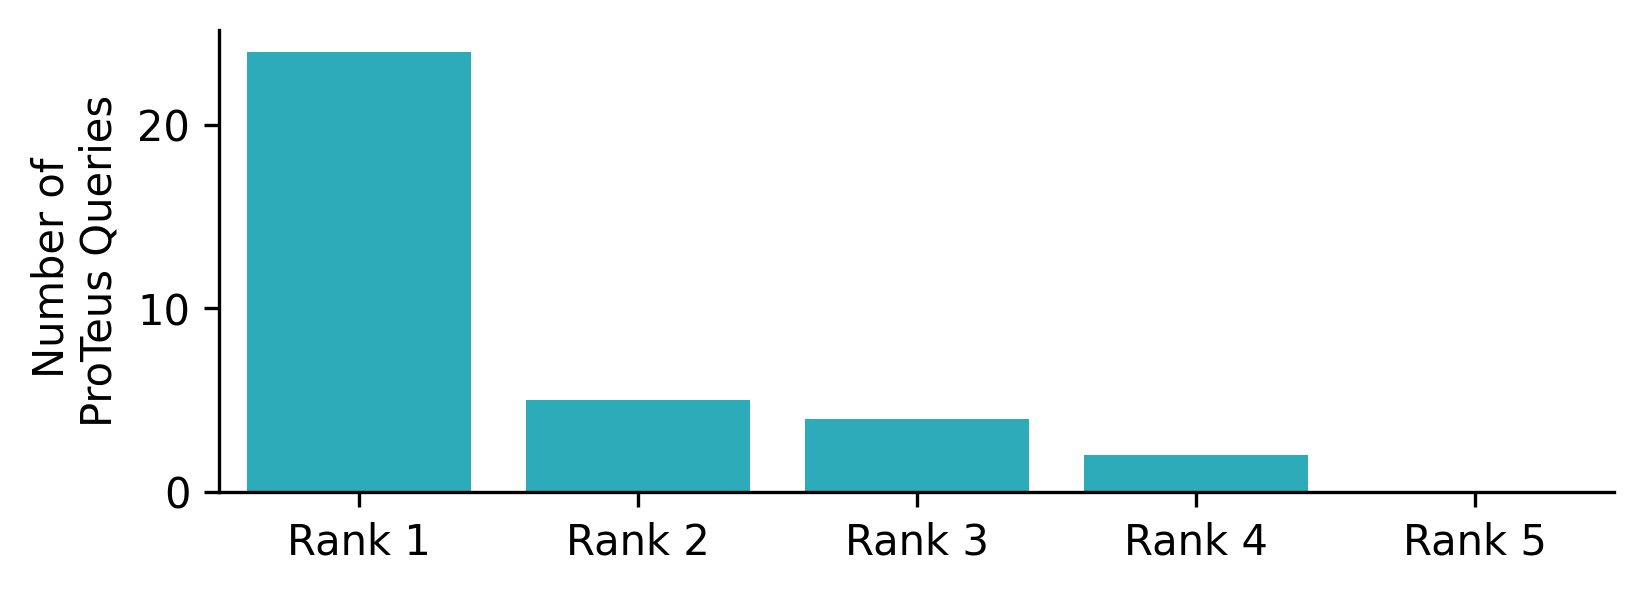

In [111]:
import seaborn as sns
flat_abs_counts = [(flat_abs_rank == i).sum() for i in sorted(np.unique(flat_abs_rank))] + [0]

plt.figure(dpi=300, figsize=(6,2))
sns.barplot(flat_abs_counts, color = "#17BECF")
sns.despine()
plt.xticks(plt.xticks()[0], ["Rank 1", "Rank 2", "Rank 3", "Rank 4", "Rank 5"])
plt.ylabel("Number of \nProTeus Queries")
plt.show()